In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from env import get_db_url

## Acquire

In [2]:
query = """
SELECT  bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet AS sqft, taxvaluedollarcnt AS tax_value, fips,taxamount 
FROM properties_2017
JOIN predictions_2017 USING (id)
JOIN propertylandusetype USING (propertylandusetypeid)
WHERE (transactiondate  >='2017-05-01' AND transactiondate <= '2017-06-30') AND propertylandusetypeid = '261'
AND taxvaluedollarcnt <= 1000000;
"""
df = pd.read_sql(query, get_db_url("zillow"))
df.head(3)

,bathroomcnt,bedroomcnt,sqft,tax_value,fips,taxamount
0,2.0,4.0,1604.0,498347.0,6037.0,6089.82
1,3.0,3.0,2384.0,549917.0,6037.0,6679.55
2,2.0,3.0,1574.0,235272.0,6037.0,3876.31


In [3]:
df.dtypes

bathroomcnt    float64
bedroomcnt     float64
sqft           float64
tax_value      float64
fips           float64
taxamount      float64
dtype: object

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14860 entries, 0 to 14859
Data columns (total 6 columns):
bathroomcnt    14860 non-null float64
bedroomcnt     14860 non-null float64
sqft           14828 non-null float64
tax_value      14860 non-null float64
fips           14860 non-null float64
taxamount      14828 non-null float64
dtypes: float64(6)
memory usage: 696.7 KB


## Prep

In [5]:
df = df.dropna()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14802 entries, 0 to 14859
Data columns (total 6 columns):
bathroomcnt    14802 non-null float64
bedroomcnt     14802 non-null float64
sqft           14802 non-null float64
tax_value      14802 non-null float64
fips           14802 non-null float64
taxamount      14802 non-null float64
dtypes: float64(6)
memory usage: 809.5 KB


In [7]:
df.fips.value_counts()

6037.0    11512
6059.0     2533
6111.0      757
Name: fips, dtype: int64

In [8]:
df.head(3)

,bathroomcnt,bedroomcnt,sqft,tax_value,fips,taxamount
0,2.0,4.0,1604.0,498347.0,6037.0,6089.82
1,3.0,3.0,2384.0,549917.0,6037.0,6679.55
2,2.0,3.0,1574.0,235272.0,6037.0,3876.31


In [9]:
df['tax_rate'] = df.taxamount / df.tax_value 
df.head()

,bathroomcnt,bedroomcnt,sqft,tax_value,fips,taxamount,tax_rate
0,2.0,4.0,1604.0,498347.0,6037.0,6089.82,0.012220
1,3.0,3.0,2384.0,549917.0,6037.0,6679.55,0.012146
2,2.0,3.0,1574.0,235272.0,6037.0,3876.31,0.016476
3,2.0,2.0,1619.0,340000.0,6037.0,4206.15,0.012371
4,2.0,4.0,1721.0,629951.0,6037.0,6861.51,0.010892


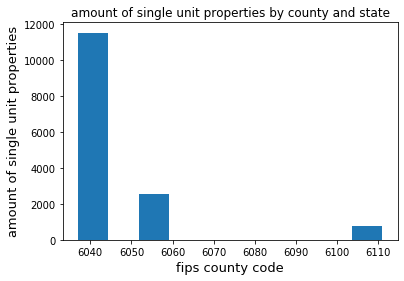

In [12]:
plt.hist(df.fips)
plt.xlabel('fips county code',fontsize=13)
plt.ylabel('amount of single unit properties',fontsize=13)
plt.title('amount of single unit properties by county and state')
plt.show()

In [25]:
df.fips.value_counts()

6037.0    11512
6059.0     2533
6111.0      757
Name: fips, dtype: int64

In [ ]:
sns.distplot(df, bins=20, kde=False, rug=True)

In [ ]:
g = sns.FacetGrid(df, col = "fips")
g.map(plt.hist, "tax_rate")
plt.xlim(-.03,.03)
plt.xticks(np.arange(-.01, .03, step=0.01))

plt.show()

In [ ]:
sns.distplot(df['bedroomcnt'],kde=False,rug=True)

In [ ]:
df.bathroomcnt.sort_values()

In [ ]:
sns.distplot(df['bathroomcnt'],kde=False,rug=True)

In [ ]:
sns.distplot(df['sqft'],kde=False,rug=False)

In [ ]:
sns.distplot(df['tax_value'],kde=False,rug=False)

In [ ]:
import split_scale

In [ ]:
train, test = split_scale.split_my_data(df)

In [ ]:
train.head()

In [ ]:
train.bathroomcnt.mean()

In [ ]:
train.bedroomcnt.mean()

In [ ]:
train.sqft.mean()

In [ ]:
print(train.shape); print(test.shape)

In [ ]:
scaler, train, test = split_scale.standard_scaler(train, test)

In [ ]:
train.head(3)

In [ ]:
sns.pairplot(df, kind="reg")
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(train.corr(), cmap='Blues', annot=True)
plt.ylim(0, 4)

## Exploration

$H_0$: There is a linear relationship between sqft and tax_value.

$H_a$: There is no linear relationship between sqft and tax_value.

In [ ]:
from math import sqrt
from scipy import stats

In [ ]:
alpha = 0.01
r, p = stats.pearsonr(train.sqft, train.tax_value)
r, p

In [ ]:
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null")

In [ ]:
alpha = 0.01
r, p = stats.pearsonr(train.bathroomcnt, train.tax_value)
r, p

In [ ]:
alpha = 0.01
r, p = stats.pearsonr(train.bedroomcnt, train.tax_value)
r, p

In [ ]:
alpha = 0.01
r, p = stats.pearsonr(train.bedroomcnt, train.sqft)
r, p

In [ ]:
alpha = 0.01
r, p = stats.pearsonr(train.bedroomcnt, train.bathroomcnt)
r, p

In [ ]:
predictions = pd.DataFrame({
    'actual_tax_value': train.tax_value
})
predictions.head()

In [ ]:
from sklearn.metrics import mean_squared_error, explained_variance_score
#from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import sklearn.linear_model
import warnings
warnings.filterwarnings("ignore")
import split_scale

In [ ]:
X = train[['bathroomcnt','bedroomcnt']]
y = train.tax_value
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
predictions['bath&bed_lm'] = lm.predict(X)

In [ ]:
predictions.head(3)

In [ ]:
X = train[['bathroomcnt','bedroomcnt','sqft']]
y = train.tax_value
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
predictions['bath&bed&sqft_lm'] = lm.predict(X)

In [ ]:
predictions.head(3)

In [ ]:
predictions['baseline'] = predictions.actual_tax_value.mean()
predictions.head(3)

In [ ]:
X = train[['bathroomcnt']]
y = train.tax_value
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
predictions['bath_lm'] = lm.predict(X)

In [ ]:
X = train[['bedroomcnt',]]
y = train.tax_value
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
predictions['bed&sqft_lm'] = lm.predict(X)

In [ ]:
X = train[['sqft']]
y = train.tax_value
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
predictions['sqft_lm'] = lm.predict(X)

In [ ]:
X = train[['bedroomcnt','sqft']]
y = train.tax_value
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
predictions['bed&sqft_lm'] = lm.predict(X)

In [ ]:
X = train[['bathroomcnt','sqft']]
y = train.tax_value
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
predictions['bath&sqft_lm'] = lm.predict(X)

In [ ]:
predictions.apply(lambda col: sklearn.metrics.mean_squared_error(predictions.actual_tax_value, col))

In [ ]:
def select_rfe(X, y, k):
    lm = sklearn.linear_model.LinearRegression()
    rfe = sklearn.feature_selection.RFE(lm, k)
    rfe.fit(X, y)
    return X.columns[rfe.support_]

In [ ]:
X = train[['bathroomcnt','bedroomcnt','sqft']]
y = train.tax_value
k = 2
select_rfe(X, y, k)

In [ ]:
def select_kbest(X, y, k):
    kbest = sklearn.feature_selection.SelectKBest(sklearn.feature_selection.f_regression, k)
    kbest.fit(X, y)
    return X.columns[kbest.get_support()]

In [ ]:
select_kbest(X, y, k)

In [ ]:
# 2. Fit a linear regression model (ordinary least squares) and compute yhat, predictions of tip using total_bill.
from statsmodels.formula.api import ols
model = ols('tax_value ~ bathroomcnt', df).fit()
df['yhat'] = model.predict(df.bathroomcnt)

In [ ]:
df.head()

In [ ]:
df.plot.scatter(y='tax_value', x='bathroomcnt')

In [ ]:
model.summary()

In [ ]:
pwd